In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Batch
from torch_geometric.nn.models import SchNet
from torch_geometric.nn.pool import global_add_pool
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import ConcatDataset
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, global_add_pool
from torch_cluster import radius_graph
import torch_cluster
import os
import csv

In [3]:
# === 1. CONFIGURATION ===
DATA_ROOT   = Path("data")
XYZ_DIR     = DATA_ROOT / "atoms" / "train"
ENERGY_CSV  = DATA_ROOT / "energies" / "train.csv"
# Force CPU to avoid torch_cluster CUDA issues
DEVICE      = torch.device('cpu')
ATOM_TYPES  = ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']


In [4]:
# === 2. UTILS ===
def atom_to_int(symbol: str) -> int:
    return ATOM_TYPES.index(symbol)

In [5]:
# === 3. DATASET & AUGMENTATION ===
class QM7XDataset(torch.utils.data.Dataset):
    def __init__(self, xyz_dir, energy_csv):
        self.xyz_dir   = Path(xyz_dir)
        self.energy_df = pd.read_csv(energy_csv, index_col='id')

    def __len__(self):
        return len(self.energy_df)

    def _load_xyz(self, file_path):
        lines = open(file_path).read().splitlines()[2:]
        atoms, pos = [], []
        for line in lines:
            s, x, y, z = line.split()
            atoms.append(atom_to_int(s))
            pos.append([float(x), float(y), float(z)])
        return torch.tensor(atoms, dtype=torch.long), torch.tensor(pos, dtype=torch.float)

    def augment(self, pos):
        # random rotation via quaternion
        u = torch.rand(3)
        q = torch.tensor([
            torch.sqrt(1-u[0]) * torch.sin(2*torch.pi*u[1]),
            torch.sqrt(1-u[0]) * torch.cos(2*torch.pi*u[1]),
            torch.sqrt(u[0])   * torch.sin(2*torch.pi*u[2]),
            torch.sqrt(u[0])   * torch.cos(2*torch.pi*u[2])
        ])
        w, x, y, z = q
        R = torch.tensor([
            [1-2*(y**2+z**2), 2*(x*y - z*w),   2*(x*z + y*w)],
            [2*(x*y + z*w),   1-2*(x**2+z**2), 2*(y*z - x*w)],
            [2*(x*z - y*w),   2*(y*z + x*w),   1-2*(x**2+y**2)]
        ])
        t = torch.randn(3)
        return pos @ R.T + t

    def __getitem__(self, idx):
        mol_id   = idx + 1
        xyz_file = self.xyz_dir / f"id_{mol_id}.xyz"
        z, pos   = self._load_xyz(xyz_file)
        # two augmented views
        pos1 = self.augment(pos)
        pos2 = self.augment(pos)
        data1 = Data(z=z, pos=pos1)
        data2 = Data(z=z, pos=pos2)
        return data1, data2

# custom collate for two-view batches
def collate_fn(batch):
    views1, views2 = zip(*batch)
    return Batch.from_data_list(views1), Batch.from_data_list(views2)


In [9]:
class UnlabeledContrastive(torch.utils.data.Dataset):
    def __init__(self, xyz_dir, cutoff=5.0):
        self.xyz_files = sorted(Path(xyz_dir).glob("*.xyz"))
        self.cutoff = cutoff

    def __len__(self):
        return len(self.xyz_files)

    def _load_xyz(self, file_path):
        lines = open(file_path).read().splitlines()[2:]
        atoms, pos = [], []
        for line in lines:
            s, x, y, z = line.split()
            atoms.append(atom_to_int(s))
            pos.append([float(x), float(y), float(z)])
        return torch.tensor(atoms, dtype=torch.long), torch.tensor(pos, dtype=torch.float)

    def augment(self, pos):
        u = torch.rand(3)
        q = torch.tensor([
            torch.sqrt(1-u[0]) * torch.sin(2*torch.pi*u[1]),
            torch.sqrt(1-u[0]) * torch.cos(2*torch.pi*u[1]),
            torch.sqrt(u[0])   * torch.sin(2*torch.pi*u[2]),
            torch.sqrt(u[0])   * torch.cos(2*torch.pi*u[2])
        ])
        w, x, y, z = q
        R = torch.tensor([
            [1-2*(y**2+z**2), 2*(x*y - z*w),   2*(x*z + y*w)],
            [2*(x*y + z*w),   1-2*(x**2+z**2), 2*(y*z - x*w)],
            [2*(x*z - y*w),   2*(y*z + x*w),   1-2*(x**2+y**2)]
        ])
        t = torch.randn(3)
        return pos @ R.T + t

    def __getitem__(self, idx):
        z, pos = self._load_xyz(self.xyz_files[idx])
        pos1 = self.augment(pos)
        pos2 = self.augment(pos)
        return Data(z=z, pos=pos1), Data(z=z, pos=pos2)

In [ ]:

# === 4. MODEL (avec GraphSAGE) ===
class GraphEncoder(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=3, cutoff=5.0):
        super().__init__()
        # Atom type embedding
        self.atom_embed = nn.Embedding(len(ATOM_TYPES), hidden_dim)
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.act = nn.ReLU()
        self.cutoff = cutoff

    def forward(self, data):
        # data.z: [num_nodes], data.pos: [num_nodes,3], data.batch: [num_nodes]
        x = self.atom_embed(data.z)
        # build edge index based on distance cutoff
        edge_index = radius_graph(data.pos, r=self.cutoff, batch=data.batch, loop=False)
        # GraphSAGE layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.act(x)
        # global pooling to get [batch_size, hidden_dim]
        h_graph = global_add_pool(x, data.batch)
        return h_graph
    
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=64, out_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [19]:
# === 5. CONTRASTIVE LOSS ===
def nt_xent_loss(z1, z2, temperature=0.1):
    batch_size = z1.size(0)
    z = torch.cat([z1, z2], dim=0)
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1) / temperature
    mask = ~torch.eye(2*batch_size, device=z.device).bool()
    exp_sim = torch.exp(sim) * mask
    pos = torch.exp(F.cosine_similarity(z1, z2) / temperature)
    pos = torch.cat([pos, pos], dim=0)
    loss = -torch.log(pos / exp_sim.sum(dim=1))
    return loss.mean()

Epoch 001 | Avg Loss: 3.6436
Epoch 002 | Avg Loss: 2.6044
Epoch 003 | Avg Loss: 2.1880
Epoch 004 | Avg Loss: 1.8527
Epoch 005 | Avg Loss: 1.4701
Epoch 006 | Avg Loss: 1.4235
Epoch 007 | Avg Loss: 1.1975
Epoch 008 | Avg Loss: 1.0734
Epoch 009 | Avg Loss: 1.0159
Epoch 010 | Avg Loss: 0.9091
Epoch 011 | Avg Loss: 0.8211
Epoch 012 | Avg Loss: 0.7569
Epoch 013 | Avg Loss: 0.7326
Epoch 014 | Avg Loss: 0.6576
Epoch 015 | Avg Loss: 0.6177
Epoch 016 | Avg Loss: 0.5903
Epoch 017 | Avg Loss: 0.5775
Epoch 018 | Avg Loss: 0.5335
Epoch 019 | Avg Loss: 0.5339
Epoch 020 | Avg Loss: 0.5086
Epoch 021 | Avg Loss: 0.4740
Epoch 022 | Avg Loss: 0.4751
Epoch 023 | Avg Loss: 0.4362
Epoch 024 | Avg Loss: 0.4452
Epoch 025 | Avg Loss: 0.4215
Epoch 026 | Avg Loss: 0.4106
Epoch 027 | Avg Loss: 0.4478
Epoch 028 | Avg Loss: 0.4287
Epoch 029 | Avg Loss: 0.4077
Epoch 030 | Avg Loss: 0.3856
Epoch 031 | Avg Loss: 0.3674
Epoch 032 | Avg Loss: 0.3800
Epoch 033 | Avg Loss: 0.3484
Epoch 034 | Avg Loss: 0.3632
Epoch 035 | Av

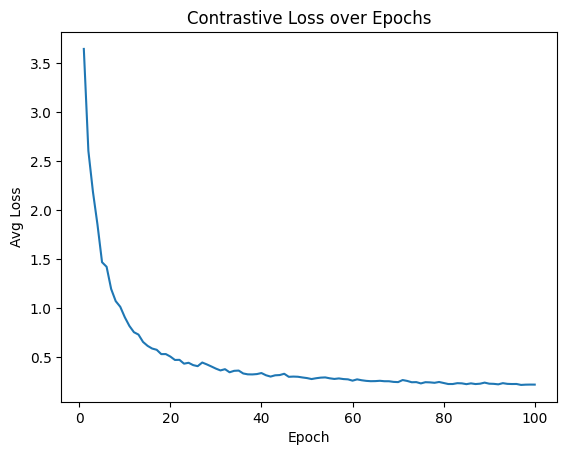

In [20]:
# === 6. TRAINING LOOP ===
test_xyz_dir = DATA_ROOT / "atoms" / "test"
test_ds = UnlabeledContrastive(test_xyz_dir)
train_ds = QM7XDataset(XYZ_DIR, ENERGY_CSV)

# Concaténation pour contraste
dataset = ConcatDataset([train_ds, test_ds])


epochs=100
batch_size=256
lr=1e-3
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                    collate_fn=collate_fn, num_workers=4)
encoder   = GraphEncoder().to(DEVICE)
projector = ProjectionHead().to(DEVICE)
optimizer = torch.optim.Adam(list(encoder.parameters()) +
                                list(projector.parameters()), lr=lr)
loss_history = []  # stocke la loss moyenne par epoch

for epoch in range(1, epochs+1):
    encoder.train(); projector.train()
    total_loss = 0.0
    for data1, data2 in loader:
        data1, data2 = data1.to(DEVICE), data2.to(DEVICE)
        h1 = encoder(data1)
        h2 = encoder(data2)
        z1 = F.normalize(projector(h1), dim=1)
        z2 = F.normalize(projector(h2), dim=1)
        loss = nt_xent_loss(z1, z2)
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * (int(data1.batch.max().item())+1)
    avg_loss = total_loss / len(dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch:03d} | Avg Loss: {avg_loss:.4f}")
# Sauvegarde de l'encodeur entraîné
torch.save(encoder.state_dict(), 'encoder_contrastive.pth')
# Plot des losses
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.xlabel('Epoch')
plt.ylabel('Avg Loss')
plt.title('Contrastive Loss over Epochs')
plt.show(f" {epoch:03d} | Avg Loss: {total_loss/len(dataset):.4f}")
# Sauvegarde de l'encodeur entraîné
torch.save(encoder.state_dict(), 'encoder_contrastive.pth')

# Visualisation des embbedings

In [24]:
def augment(pos):
    # random rotation via quaternion + translation
    u = torch.rand(3)
    q = torch.tensor([
        torch.sqrt(1-u[0]) * torch.sin(2*torch.pi*u[1]),
        torch.sqrt(1-u[0]) * torch.cos(2*torch.pi*u[1]),
        torch.sqrt(u[0])   * torch.sin(2*torch.pi*u[2]),
        torch.sqrt(u[0])   * torch.cos(2*torch.pi*u[2])
    ])
    w, x, y, z = q
    R = torch.tensor([
        [1-2*(y**2+z**2), 2*(x*y - z*w),   2*(x*z + y*w)],
        [2*(x*y + z*w),   1-2*(x**2+z**2), 2*(y*z - x*w)],
        [2*(x*z - y*w),   2*(y*z + x*w),   1-2*(x**2+y**2)]
    ])
    t = torch.randn(3)
    return pos @ R.T + t

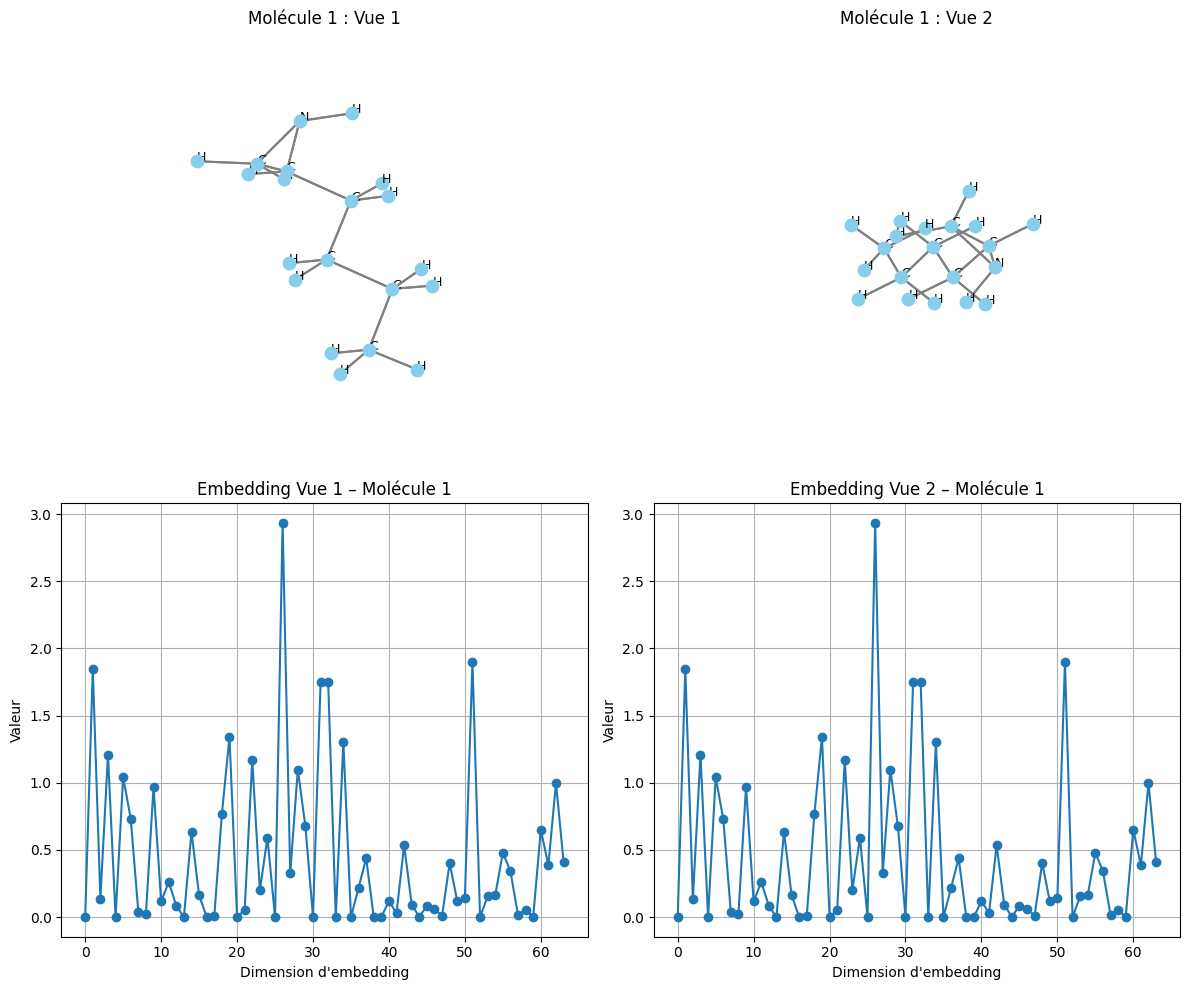

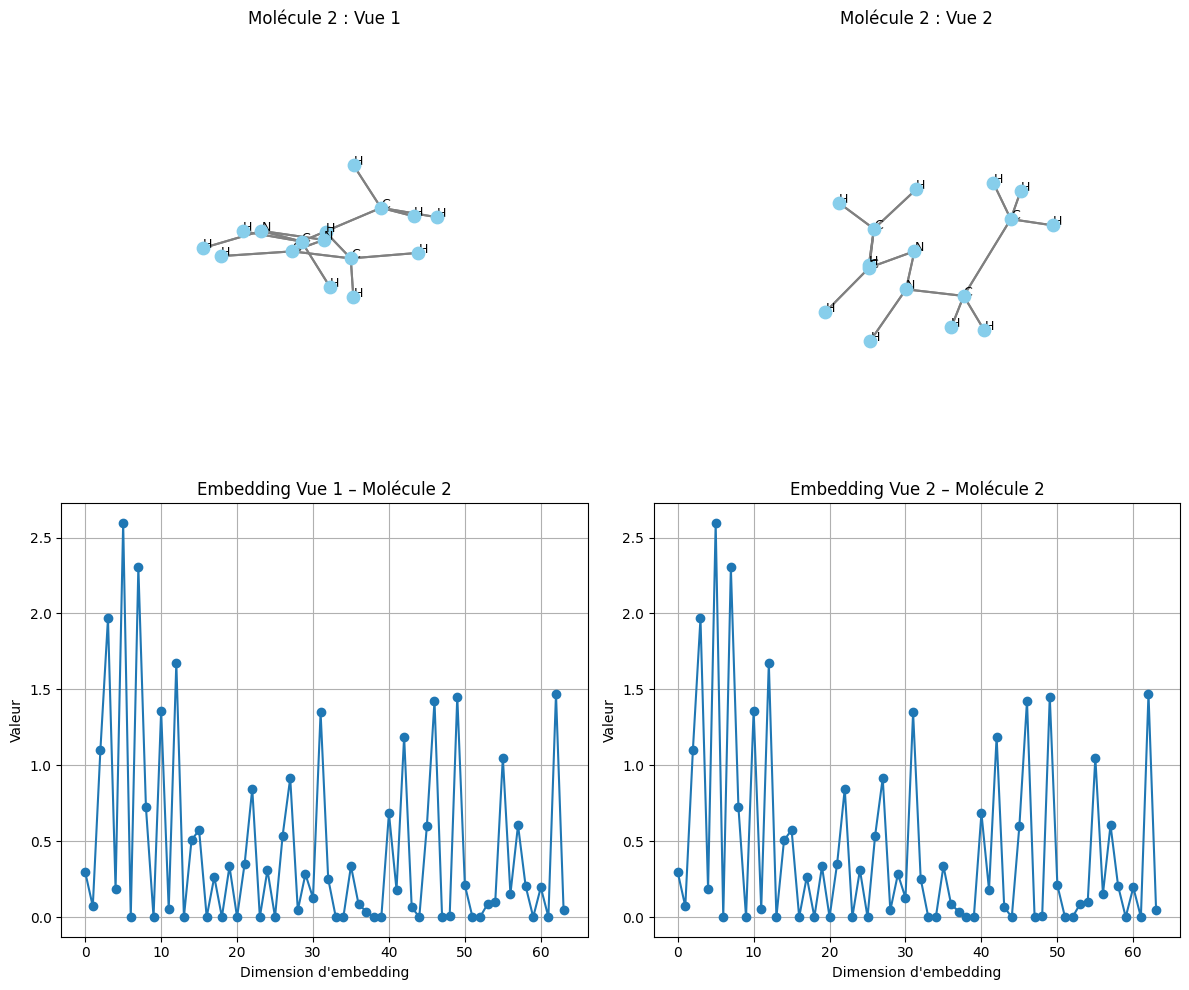

In [25]:
def load_molecule(file_path):
    lines = open(file_path).read().splitlines()[2:]
    atoms, pos_list = [], []
    for line in lines:
        s, x, y, z = line.split()
        atoms.append(s)
        pos_list.append([float(x), float(y), float(z)])
    return atoms, torch.tensor(pos_list, dtype=torch.float)

def plot_molecule(ax, pos, atoms, cutoff=1.7, title=""):
    for i, (atom, coord) in enumerate(zip(atoms, pos.numpy())):
        ax.scatter(*coord, s=80, color='skyblue', depthshade=True)
        ax.text(coord[0], coord[1], coord[2], atom, fontsize=9)
    batch = torch.zeros(len(atoms), dtype=torch.long)
    edge_index = torch_cluster.radius_graph(pos, r=cutoff, batch=batch, loop=False)
    for u, v in edge_index.t().numpy():
        c1 = pos[u].numpy()
        c2 = pos[v].numpy()
        ax.plot([c1[0], c2[0]], [c1[1], c2[1]], [c1[2], c2[2]], color='gray', linewidth=1.5)
    ax.set_title(title)
    ax.set_axis_off()

encoder = GraphEncoder().to(DEVICE)
encoder.load_state_dict(torch.load('encoder_contrastive.pth', map_location=DEVICE))
encoder.eval()

# === PROCESS TWO MOLECULES ===
files = sorted(XYZ_DIR.glob("*.xyz"))[:2]

for idx, file_path in enumerate(files):
    atoms, pos = load_molecule(file_path)
    pos1 = augment(pos)
    pos2 = augment(pos)

    # Calcul des embeddings
    data1 = Data(z=torch.tensor([atom_to_int(a) for a in atoms]),
                pos=pos1, batch=torch.zeros(len(atoms), dtype=torch.long))
    data2 = Data(z=torch.tensor([atom_to_int(a) for a in atoms]),
                pos=pos2, batch=torch.zeros(len(atoms), dtype=torch.long))
    with torch.no_grad():
        h1 = encoder(data1.to(DEVICE)).cpu().numpy().reshape(-1)
        h2 = encoder(data2.to(DEVICE)).cpu().numpy().reshape(-1)
    dims = np.arange(len(h1))

    # Création de la figure 2×2
    fig = plt.figure(figsize=(12,10))

    # Vue 3D – View 1
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    plot_molecule(ax1, pos1, atoms, title=f'Molécule {idx+1} : Vue 1')

    # Vue 3D – View 2
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    plot_molecule(ax2, pos2, atoms, title=f'Molécule {idx+1} : Vue 2')

    # Embedding dimension – Vue 1 uniquement
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.plot(dims, h1, marker='o')
    ax3.set_xlabel('Dimension d\'embedding')
    ax3.set_ylabel('Valeur')
    ax3.set_title(f'Embedding Vue 1 – Molécule {idx+1}')
    ax3.grid(True)

    # Embedding dimension – Vue 2 uniquement
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.plot(dims, h2, marker='o')
    ax4.set_xlabel('Dimension d\'embedding')
    ax4.set_ylabel('Valeur')
    ax4.set_title(f'Embedding Vue 2 – Molécule {idx+1}')
    ax4.grid(True)

    plt.tight_layout()
    plt.show()



# Prédiction sur les embbedings

In [26]:
class QM7XEmbedDataset(QM7XDataset):
    def __getitem__(self, idx):
        mol_id   = idx + 1
        xyz_file = self.xyz_dir / f"id_{mol_id}.xyz"
        z, pos   = self._load_xyz(xyz_file)
        data     = Data(z=z, pos=pos)
        data.batch = torch.zeros(z.size(0), dtype=torch.long)
        return data, float(self.energy_df.loc[mol_id, 'energy'])


In [27]:
# === 8. EXTRACTION DES EMBEDDINGS MULTI-CALQUES ===
# 1) On étend GraphEncoder pour exposer les sorties de chaque layer
class FeatureGraphEncoder(GraphEncoder):
    def extract_features(self, data):
        # data.z, data.pos, data.batch
        x = self.atom_embed(data.z)
        pos, batch = data.pos, data.batch
        features = []

        # couche “0” : embedding initial mis en pool
        h0 = global_add_pool(x, batch)
        features.append(h0)

        # chaque convolution + activation + pool
        for conv in self.convs:
            # reconstruire edge_index à chaque fois
            edge_index = radius_graph(pos, r=self.cutoff, batch=batch, loop=False)
            x = conv(x, edge_index)
            x = self.act(x)
            h = global_add_pool(x, batch)
            features.append(h)

        # renvoie liste de tenseurs [batch_size, hidden_dim]
        return features

# 2) Charger l'encodeur entraîné
fencoder = FeatureGraphEncoder().to(DEVICE)
fencoder.load_state_dict(torch.load('encoder_contrastive.pth', map_location=DEVICE))
fencoder.eval()

# 3) Parcours du dataset pour extraire et concaténer toutes les couches
embed_dataset = QM7XEmbedDataset(XYZ_DIR, ENERGY_CSV)
feature_list, y_list = [], []
for idx in range(len(embed_dataset)):
    data, energy = embed_dataset[idx]
    data = data.to(DEVICE)
    with torch.no_grad():
        feats = fencoder.extract_features(data)  # liste de [1, hidden_dim]
    # concaténation le long de la dimension features
    flat = torch.cat(feats, dim=1).cpu().numpy().reshape(-1)
    feature_list.append(flat)
    y_list.append(energy)

import numpy as np
X = np.vstack(feature_list)   # shape [N, (num_layers+1)*hidden_dim]
y = np.array(y_list)          # shape [N]


### XGBoost

In [28]:
# === 9. RÉGRESSION AVEC XGBOOST === AVEC XGBOOST ===
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 6,
    'seed': 42,
}
wlist = [(dtrain, 'train'), (dtest, 'eval')]
model_xgb = xgb.train(params, dtrain, num_boost_round=200, evals=wlist)

# Prédictions et évaluation
y_pred = model_xgb.predict(dtest)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2   = r2_score(y_test, y_pred)
print(f"XGB RMSE: {rmse:.4f}, R2: {r2:.4f}")

[0]	train-rmse:10.43502	eval-rmse:10.77328
[1]	train-rmse:9.40764	eval-rmse:9.71309
[2]	train-rmse:8.48277	eval-rmse:8.75765
[3]	train-rmse:7.65002	eval-rmse:7.89522
[4]	train-rmse:6.90001	eval-rmse:7.12133
[5]	train-rmse:6.22476	eval-rmse:6.42404
[6]	train-rmse:5.61671	eval-rmse:5.79515
[7]	train-rmse:5.06958	eval-rmse:5.22724
[8]	train-rmse:4.57679	eval-rmse:4.72382
[9]	train-rmse:4.13339	eval-rmse:4.26741
[10]	train-rmse:3.73383	eval-rmse:3.85583
[11]	train-rmse:3.37382	eval-rmse:3.48515
[12]	train-rmse:3.05000	eval-rmse:3.15336
[13]	train-rmse:2.75897	eval-rmse:2.85374
[14]	train-rmse:2.49723	eval-rmse:2.58755
[15]	train-rmse:2.26171	eval-rmse:2.34505
[16]	train-rmse:2.05053	eval-rmse:2.13060
[17]	train-rmse:1.86094	eval-rmse:1.93854
[18]	train-rmse:1.69027	eval-rmse:1.76390
[19]	train-rmse:1.53743	eval-rmse:1.61009
[20]	train-rmse:1.40060	eval-rmse:1.47349
[21]	train-rmse:1.27830	eval-rmse:1.35322
[22]	train-rmse:1.16860	eval-rmse:1.24458
[23]	train-rmse:1.07107	eval-rmse:1.14755


# Prédiction sur embbeding + scattering

In [29]:
import pickle
scattering = pickle.load(open("scattering_coef_64_64_64.pkl", "rb"))
#scattering = pickle.load(open("scattering_coef_train_32_32_32.pkl", "rb"))

In [30]:
N_emb, dim_emb = X.shape
N_scat, dim_scat = scattering.shape
assert N_emb == N_scat, (
    f"Le nombre d’échantillons ({N_emb}) et de scattering "
    f"({N_scat}) doit être identique."
)


In [31]:
X = np.hstack([X, scattering])

### XGBoost

In [32]:
# === 9. RÉGRESSION AVEC XGBOOST === AVEC XGBOOST ===
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 8,
    'seed': 42,
    'alpha': 0.1,    # poids de la pénalité L1
    'lambda': 10.0,   # poids de la pénalité L2
}
wlist = [(dtrain, 'train'), (dtest, 'eval')]
model_xgb = xgb.train(params, dtrain, num_boost_round=500, evals=wlist)

# Prédictions et évaluation
y_pred = model_xgb.predict(dtest)
rmse = mean_squared_error(y_test, y_pred)**0.5
mae = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print(f"XGB RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")

[0]	train-rmse:10.47315	eval-rmse:10.81237
[1]	train-rmse:9.48030	eval-rmse:9.78434
[2]	train-rmse:8.58687	eval-rmse:8.86463
[3]	train-rmse:7.77969	eval-rmse:8.02080
[4]	train-rmse:7.05431	eval-rmse:7.26472
[5]	train-rmse:6.39987	eval-rmse:6.57675
[6]	train-rmse:5.80985	eval-rmse:5.96387
[7]	train-rmse:5.27810	eval-rmse:5.41968
[8]	train-rmse:4.79612	eval-rmse:4.92937
[9]	train-rmse:4.36274	eval-rmse:4.47720
[10]	train-rmse:3.97121	eval-rmse:4.07499
[11]	train-rmse:3.61709	eval-rmse:3.70550
[12]	train-rmse:3.29660	eval-rmse:3.37258
[13]	train-rmse:3.00764	eval-rmse:3.07786
[14]	train-rmse:2.74644	eval-rmse:2.80968
[15]	train-rmse:2.51107	eval-rmse:2.56907
[16]	train-rmse:2.29941	eval-rmse:2.34641
[17]	train-rmse:2.10766	eval-rmse:2.15045
[18]	train-rmse:1.93413	eval-rmse:1.97313
[19]	train-rmse:1.77843	eval-rmse:1.81294
[20]	train-rmse:1.63746	eval-rmse:1.67082
[21]	train-rmse:1.51041	eval-rmse:1.54269
[22]	train-rmse:1.39600	eval-rmse:1.42611
[23]	train-rmse:1.29294	eval-rmse:1.32041


### Stacking

In [27]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1) Définir les estimateurs sklearn-compatibles

# XGBoost
xgb_sk = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.1,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=10.0,
    n_estimators=100,
    random_state=42,
    verbosity=0
)

# LightGBM
lgb_sk = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=10.0,
    n_estimators=100,
    random_state=42
)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

# 2) Entraîner chaque modèle sur vos données
xgb_sk.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
lgb_sk.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
)
rf.fit(X_train, y_train)

# 3) Créer et entraîner le stacking
estimators = [
    ('xgb', xgb_sk),
    ('lgb', lgb_sk),
    ('rf', rf)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X_train, y_train)

# 4) Évaluer
y_pred = stack.predict(X_test)
print(f"Stacking RMSE: {mean_squared_error(y_test, y_pred)**0.5:.4f}")
print(f"Stacking R²:   {r2_score(y_test, y_pred):.4f}")
print(f"Stacking MAE:  {mean_absolute_error(y_test, y_pred):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200771
[LightGBM] [Info] Number of data points in the train set: 5272, number of used features: 884
[LightGBM] [Info] Start training from score -77.975986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, 

Stacking RMSE: 0.2664
Stacking R²:   0.9995
Stacking MAE:  0.1437


/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [31]:
import joblib

# Sauvegarde
joblib.dump(stack, 'stacking_model.pkl')

# Chargement ultérieur
stack_loaded = joblib.load('stacking_model.pkl')


### Regression mutli-linear

In [ ]:
# Module ElementwiseProd
class ElementwiseProd(nn.Module):
    def __init__(self, N, q, k):
        super().__init__()
        self.N = N
        self.q = q
        self.k = k
        self.W = nn.ParameterList([nn.Parameter(torch.randn(N, q)) for _ in range(k)])
        self.b = nn.ParameterList([nn.Parameter(torch.randn(q)) for _ in range(k)])
        self.act = torch.sigmoid

    def forward(self, x):
        outs = []
        for i in range(self.k):
            y = x @ self.W[i] + self.b[i]
            y = self.act(y)
            outs.append(y)
        prod = outs[0]
        for i in range(1, self.k):
            prod = prod * outs[i]
        return prod

# Modèle complet de régression
class RegressionModel(nn.Module):
    def __init__(self, input_dim, q, k):
        super().__init__()
        self.elem = ElementwiseProd(input_dim, q, k)
        self.fc = nn.Linear(q, 1)

    def forward(self, x):
        x = self.elem(x)
        out = self.fc(x)
        return out

Epoch 1/400, Loss: 6261.7420
Epoch 10/400, Loss: 5808.5882
Epoch 20/400, Loss: 5332.5617
Epoch 30/400, Loss: 4878.8460
Epoch 40/400, Loss: 4447.5814
Epoch 50/400, Loss: 4036.4885
Epoch 60/400, Loss: 3647.9573
Epoch 70/400, Loss: 3280.1651
Epoch 80/400, Loss: 2933.2051
Epoch 90/400, Loss: 2606.6805
Epoch 100/400, Loss: 2301.8725
Epoch 110/400, Loss: 2017.3302
Epoch 120/400, Loss: 1753.8591
Epoch 130/400, Loss: 1510.9586
Epoch 140/400, Loss: 1288.3289
Epoch 150/400, Loss: 1087.0619
Epoch 160/400, Loss: 905.7590
Epoch 170/400, Loss: 744.8331
Epoch 180/400, Loss: 604.0207
Epoch 190/400, Loss: 482.4783
Epoch 200/400, Loss: 380.8835
Epoch 210/400, Loss: 298.4048
Epoch 220/400, Loss: 234.0397
Epoch 230/400, Loss: 187.4921
Epoch 240/400, Loss: 157.4079
Epoch 250/400, Loss: 141.0456
Epoch 260/400, Loss: 135.0318
Epoch 270/400, Loss: 133.7287
Epoch 280/400, Loss: 133.7112
Epoch 290/400, Loss: 133.8408
Epoch 300/400, Loss: 133.5850
Epoch 310/400, Loss: 133.6086
Epoch 320/400, Loss: 133.5292
Epoch

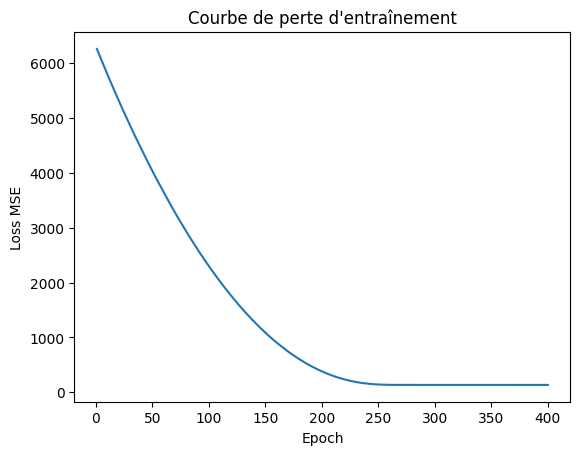

PyTorch RMSE: 11.9550, R2: -0.0017, MAE: 9.8775


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Données X, y: numpy arrays
# Exemple: X = np.array(...), y = np.array(...)

# Paramètres
batch_size = 32
lr = 1e-3
epochs = 400

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Conversion en tenseurs PyTorch
torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float().unsqueeze(1)

# DataLoaders
dataset_train = TensorDataset(X_train_t, y_train_t)
dataset_test = TensorDataset(X_test_t, y_test_t)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size)

# Initialisation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = X.shape[1]
q = 10
k = 3
model = RegressionModel(input_dim, q, k).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Entraînement avec suivi de la loss
history = []
for epoch in range(1, epochs+1):
    model.train()
    train_losses = []
    for xb, yb in loader_train:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    history.append(avg_loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

# Plot de la loss d'entraînement
plt.figure()
plt.plot(range(1, epochs+1), history)
plt.xlabel('Epoch')
plt.ylabel('Loss MSE')
plt.title("Courbe de perte d'entraînement")
plt.show()

# Évaluation sur test
model.eval()
with torch.no_grad():
    preds_test = model(X_test_t.to(device)).cpu().squeeze().numpy()
rmse = mean_squared_error(y_test, preds_test)**0.5
mae = mean_absolute_error(y_test, preds_test)
r2 = r2_score(y_test, preds_test)
print(f"PyTorch RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")


Epoch 1/100, Loss: 6120.4682
Epoch 10/100, Loss: 700.6570
Epoch 20/100, Loss: 134.0114
Epoch 30/100, Loss: 134.0334
Epoch 40/100, Loss: 134.0829
Epoch 50/100, Loss: 134.0863
Epoch 60/100, Loss: 134.0807
Epoch 70/100, Loss: 133.8748
Epoch 80/100, Loss: 133.6499
Epoch 90/100, Loss: 133.6725
Epoch 100/100, Loss: 133.7128


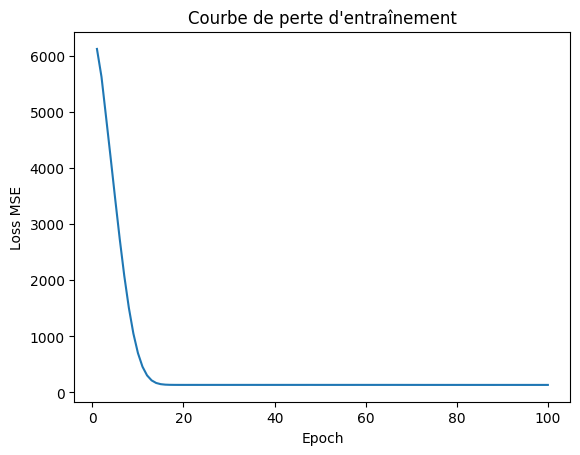

TypeError: got an unexpected keyword argument 'squared'

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Données X, y: numpy arrays
# Exemple: X = np.array(...), y = np.array(...)

# Paramètres
batch_size = 32
lr = 1e-3
epochs = 100
q = 10            # taille de sortie d'ElementwiseProd
k = 3             # nombre de multiplicateurs dans ElementwiseProd
num_elem_layers = 2  # nombre d'ElementwiseProd empilés

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Conversion en tenseurs PyTorch
torch.manual_seed(42)
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float().unsqueeze(1)

# DataLoaders
dataset_train = TensorDataset(X_train_t, y_train_t)
dataset_test = TensorDataset(X_test_t, y_test_t)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size)

# Module ElementwiseProd
class ElementwiseProd(nn.Module):
    def __init__(self, in_dim, q, k):
        super().__init__()
        self.k = k
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_dim, q, bias=False),
                nn.Sigmoid()
            ) for _ in range(k)
        ])
        self.bias = nn.Parameter(torch.zeros(q))

    def forward(self, x):
        # calcule k projections, puis multiplie élémentwise
        outs = [layer(x) for layer in self.layers]
        prod = outs[0]
        for y in outs[1:]:
            prod = prod * y
        return prod + self.bias

# Modèle combinant plusieurs ElementwiseProd
class RegressionModel(nn.Module):
    def __init__(self, input_dim, q, k, num_layers):
        super().__init__()
        self.elem_layers = nn.ModuleList([
            ElementwiseProd(input_dim if i==0 else q, q, k)
            for i in range(num_layers)
        ])
        self.fc = nn.Linear(q, 1)

    def forward(self, x):
        for elem in self.elem_layers:
            x = elem(x)
        out = self.fc(x)
        return out

# Initialisation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = X.shape[1]
model = RegressionModel(input_dim, q, k, num_elem_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Entraînement avec suivi de la loss
history = []
for epoch in range(1, epochs+1):
    model.train()
    train_losses = []
    for xb, yb in loader_train:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_loss = np.mean(train_losses)
    history.append(avg_loss)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")

# Plot de la loss d'entraînement
plt.figure()
plt.plot(range(1, epochs+1), history)
plt.xlabel('Epoch')
plt.ylabel('Loss MSE')
plt.title("Courbe de perte d'entraînement")
plt.show()

# Évaluation sur test
model.eval()
with torch.no_grad():
    preds_test = model(X_test_t.to(device)).cpu().squeeze().numpy()
rmse = mean_squared_error(y_test, preds_test, squared=False)
mae = mean_absolute_error(y_test, preds_test)
r2 = r2_score(y_test, preds_test)
print(f"PyTorch RMSE: {rmse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}")


# Prédiction sur le dataset de TEST

In [50]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1) Définir les estimateurs sklearn-compatibles

# XGBoost
xgb_sk = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.1,
    max_depth=8,
    reg_alpha=0.1,
    reg_lambda=10.0,
    n_estimators=500,
    random_state=42,
    verbosity=0
)

# LightGBM
lgb_sk = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=31,
    reg_alpha=0.1,
    reg_lambda=10.0,
    n_estimators=500,
    random_state=42
)

# Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

# 2) Entraîner chaque modèle sur vos données
xgb_sk.fit(
    X, y,
    verbose=False
)
lgb_sk.fit(
    X, y,
)
rf.fit(X, y)

# 3) Créer et entraîner le stacking
estimators = [
    ('xgb', xgb_sk),
    ('lgb', lgb_sk),
    ('rf', rf)
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X, y)

# 4) Évaluer
y_pred = stack.predict(X)
print(f"Stacking RMSE: {mean_squared_error(y, y_pred)**0.5:.4f}")
print(f"Stacking R²:   {r2_score(y, y_pred):.4f}")
print(f"Stacking MAE:  {mean_absolute_error(y, y_pred):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117746
[LightGBM] [Info] Number of data points in the train set: 6591, number of used features: 482
[LightGBM] [Info] Start training from score -77.881288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 117746
[LightGBM] [Info] Number of data points in the train set: 6591, number of used fe

/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, 

Stacking RMSE: 0.0422
Stacking R²:   1.0000
Stacking MAE:  0.0185


/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# --- 1) Dataset de test multi-couches ---
class QM7XTestDataset(torch.utils.data.Dataset):
    def __init__(self, xyz_dir):
        self.xyz_dir = Path(xyz_dir)
        self.files = sorted(self.xyz_dir.glob("id_*.xyz"))

    def __len__(self):
        return len(self.files)

    def _load_xyz(self, file_path):
        lines = file_path.open().read().splitlines()[2:]
        atoms, pos = [], []
        for line in lines:
            s, x, y, z = line.split()
            atoms.append(ATOM_TYPES.index(s))
            pos.append([float(x), float(y), float(z)])
        return torch.tensor(atoms, dtype=torch.long), torch.tensor(pos, dtype=torch.float)

    def __getitem__(self, idx):
        z, pos = self._load_xyz(self.files[idx])
        data = Data(z=z, pos=pos)
        data.batch = torch.zeros(z.size(0), dtype=torch.long)
        return data

# --- 2) Charger l'encodeur multi-couches entraîné ---
fencoder = FeatureGraphEncoder().to(DEVICE)
fencoder.load_state_dict(
    torch.load('encoder_contrastive.pth', map_location=DEVICE)
)
fencoder.eval()

# --- 3) Extraire features sur le jeu de test ---
TEST_DIR = DATA_ROOT / "atoms" / "test"
test_ds = QM7XTestDataset(TEST_DIR)

feature_list = []
for data in test_ds:
    data = data.to(DEVICE)
    with torch.no_grad():
        feats = fencoder.extract_features(data)  # Liste de [1, hidden_dim]
    flat = torch.cat(feats, dim=1).cpu().numpy().reshape(-1)
    feature_list.append(flat)

X_test = np.vstack(feature_list)  # shape [N_test, (num_layers+1)*hidden_dim]
print("Forme de X_test_multi_layers :", X_test.shape)


Forme de X_test_multi_layers : (1647, 32)


In [52]:
scattering = pickle.load(open("scattering_coef_test_64_64_64.pkl", "rb"))  

X = np.hstack([X_test, scattering])

In [ ]:
# # Prédictions
data_dir = "data"
test_dir = os.path.join(data_dir, "atoms", "test")

# Récupération des fichiers .xyz
test_files = sorted([f for f in os.listdir(test_dir) if f.endswith(".xyz")])
test_ids = [int(f.split("_")[1].split(".")[0]) for f in test_files]
predicted_energies = stack.predict(X)

# Sauvegarde dans un CSV
output_file = "test_predictions_64_64_64.csv"
with open(output_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["id", "energy"])
    for mol_id, energy in zip(test_ids, predicted_energies):
        writer.writerow([mol_id, energy])

print(f"✅ Fichier de prédictions sauvegardé sous : {output_file}")

✅ Fichier de prédictions sauvegardé sous : test_predictions_64_64_64.csv


/home/n7student/miniforge3/envs/dl/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
